# Наивный Байес и спам
__Суммарное количество баллов: 10__


In [100]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import spacy
from nltk.stem.snowball import SnowballStemmer
import pandas as pd

In [6]:
import re
def read_dataset(filename):
    file = open(filename, encoding="utf-8")
    x = []
    y = []
    for line in file:
        cl, sms = re.split("^(ham|spam)[\t\s]+(.*)$", line)[1:3]
        x.append(sms)
        y.append(cl)
    return np.array(x, dtype=np.str), np.array(y, dtype=np.str)

In [7]:
def get_precision_recall_accuracy(y_pred, y_true):
    classes = np.unique(list(y_pred) + list(y_true))
    true_positive = dict((c, 0) for c in classes)
    true_negative = dict((c, 0) for c in classes)
    false_positive = dict((c, 0) for c in classes)
    false_negative = dict((c, 0) for c in classes)
    for c_pred, c_true in zip(y_pred, y_true):
        for c in classes:
            if c_true == c:
                if c_pred == c_true:
                    true_positive[c] = true_positive.get(c, 0) + 1
                else:
                    false_negative[c] = false_negative.get(c, 0) + 1
            else:
                if c_pred == c:
                    false_positive[c] = false_positive.get(c, 0) + 1
                else:
                    true_negative[c] = true_negative.get(c, 0) + 1
    precision = dict((c, true_positive[c] / (true_positive[c] + false_positive[c])) for c in classes)
    recall = dict((c, true_positive[c] / (true_positive[c] + false_negative[c])) for c in classes)
    accuracy = sum([true_positive[c] for c in classes]) / len(y_pred)
    return precision, recall, accuracy

def plot_precision_recall(X_train, y_train, X_test, y_test, bow_method, voc_sizes=range(4, 200, 5)):
    classes = np.unique(list(y_train) + list(y_test))
    precisions = dict([(c, []) for c in classes])
    recalls = dict([(c, []) for c in classes])
    accuracies = []
    for v in voc_sizes:
        bow = bow_method(X_train, voc_limit=v)
        X_train_transformed = bow.transform(X_train)
        X_test_transformed = bow.transform(X_test)
        classifier = NaiveBayes(0.001)
        classifier.fit(X_train_transformed, y_train)
        y_pred = classifier.predict(X_test_transformed)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in classes:
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("Vocabulary size")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(list(ys.values()))-0.01, np.max(list(ys.values()))+0.01)
        for c in ys.keys():
            plt.plot(x, ys[c], label="Class " + str(c))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(voc_sizes, recalls, "Recall")
    plot(voc_sizes, precisions, "Precision")
    plot(voc_sizes, {"":accuracies}, "Accuracy", legend=False)

In [9]:
X, y = read_dataset("hw6_data/spam")

<ipython-input-6-c1364a5e16ee>:10: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.array(x, dtype=np.str), np.array(y, dtype=np.str)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9)

### Задание 1 (3.5 балла)
Реализуйте классификацию методом Байеса в предположении независимости компонент `x`. При реализации следует считать, что значения каждой компоненты дискретны, а `p(x|y)` имеет мультиномиальное распределение.

#### Методы
`fit(X, y)` - оценивает параметры распределения `p(x|y)` для каждого `y`. 

`log_proba(X)` - для каждого элемента набора `X` считает логарифм вероятности отнести его к каждому классу. По теореме Байеса: `p(y|x) = p(y)p(x|y)/p(x)`. Соответственно, после логарифмирования: `log p(y|x) = log p(y) + log p(x|y) - log p(x)`. Поскольку `log p(x)` является независящей от класса `y` константой, это слагаемое никак не влияет на решение задачи максимизации. Поэтому его можно просто убрать для простоты.

In [234]:
class NaiveBayes:
    def __init__(self, alpha):
        self.alpha = alpha # Параметр аддитивной регуляризации
        self.labels = None
        self.freq = None
        self.freqxy = None
    
    def fit(self, X, y):
        labels, freq = np.unique(y, return_counts=True)
        freq = freq / len(y)
        self.labels = labels
        self.freq = {labels[i]: freq[i] for i in range(len(labels))}
        
        self.freqxy = {}
        
        for l in self.labels:
            Xl = X[y == l]
            freq_x = (np.sum(Xl, axis=0) + self.alpha) / (np.sum(Xl) + X.shape[1] * self.alpha)
            self.freqxy[l] = freq_x
            
    def predict(self, X):
        return [self.labels[i] for i in np.argmax(self.log_proba(X), axis=1)]
    
    def log_proba(self, X):
        pred = []
        
        for x in X:
            pr = []
            for l in self.labels:
                p = np.log(self.freq[l]) + np.sum(x * np.log(self.freqxy[l]))
                pr.append(p)
            pred.append(pr)
        
        pred = np.array(pred)
        
        return pred

### Задание 2 (3.5 балла)
Теперь реализуем метод bag of words. Задача состоит в том, чтобы посчитать количество вхождений каждого слова в предложение.

#### Методы
`__init__(X, voc_limit)` - инициализирует BoW, составляя словарь, который будет использоваться для векторизации предложений. Размер словаря должен быть не больше `voc_limit`, в него должны входить самые часто встречающиеся в выборке слова.

`transform(X)` - векторизует сообщения из набора.

In [235]:
class BoW:
    def __init__(self, X, voc_limit=1000):
        self.voc = None
        C = X.copy()
        
        worlds = []
        for c in C:
            worlds.extend(self._str_to_worlds(c))
        worlds = np.array(worlds)
                
        unique, counts = np.unique(worlds, return_counts=True)
        argsort = np.argsort(counts)
        
        self.voc = unique[argsort][::-1][:voc_limit]
    
    def _str_to_worlds(self, string):
        string_cl = string.lower()
        string_cl = re.sub(r'\W', ' ', string_cl)
        string_cl = re.sub(r'\s+', ' ', string_cl)
        worlds = string_cl.split(' ')
        worlds = [world for world in worlds if world not in ['', ' ']]
        return worlds
        
    def transform(self, X):
        X_transformed = np.zeros((X.shape[0], self.voc.size))
        for i, x in enumerate(X):
            worlds = self._str_to_worlds(x)
            for w in worlds:
                j = np.where(self.voc == w)
                if len(j) > 0:
                    j = j[0]
                    X_transformed[i][j] += 1
        return X_transformed

In [236]:
bow = BoW(X_train, voc_limit=500)
X_train_bow = bow.transform(X_train)
X_test_bow = bow.transform(X_test)

In [237]:
predictor = NaiveBayes(0.001)
predictor.fit(X_train_bow, y_train)
get_precision_recall_accuracy(predictor.predict(X_test_bow), y_test)

({'ham': 0.9939148073022313, 'spam': 0.9076923076923077},
 {'ham': 0.9879032258064516, 'spam': 0.9516129032258065},
 0.9838709677419355)

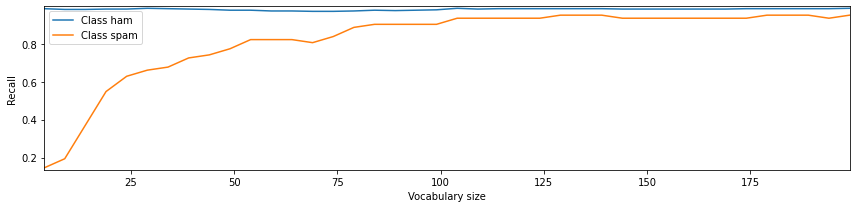

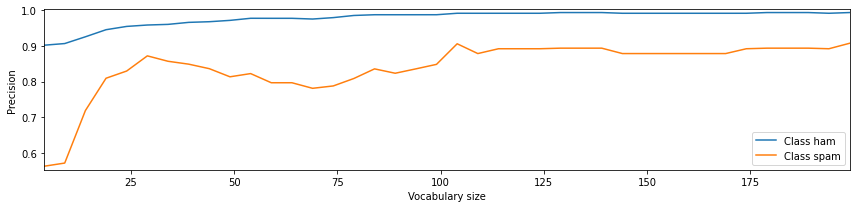

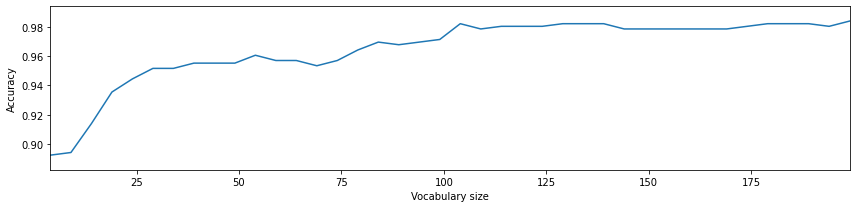

In [238]:
plot_precision_recall(X_train, y_train, X_test, y_test, BoW)

### Задание 3 (3 балла)
Теперь добавим в BoW стемминг. Для этого нам понадобится класс SnowballStemmer из пакета `nltk`

#### Методы
`__init__(X, voc_limit)` - инициализирует BoW, составляя словарь, который будет использоваться для векторизации предложений. Размер словаря должен быть не больше `voc_limit`, в него должны входить самые часто встречающиеся в выборке слова.

`transform(X)` - векторизует сообщения из набора.

In [241]:
class BowStem:
    def __init__(self, X, voc_limit=1000):
        self.stem = SnowballStemmer(language="english")
        self.voc = None
        C = X.copy()
        
        worlds = []
        for c in C:
            worlds.extend(self._str_to_worlds(c))
        worlds = np.array(worlds)
                
        unique, counts = np.unique(worlds, return_counts=True)
        argsort = np.argsort(counts)
        
        self.voc = unique[argsort][::-1][:voc_limit]
    
    def _str_to_worlds(self, string):
        string_cl = string.lower()
        string_cl = re.sub(r'\W', ' ', string_cl)
        string_cl = re.sub(r'\s+', ' ', string_cl)
        worlds = string_cl.split(' ')
        worlds = [self.stem.stem(world) for world in worlds if world not in ['', ' ']]
        return worlds
        
    def transform(self, X):
        X_transformed = np.zeros((X.shape[0], self.voc.size))
        for i, x in enumerate(X):
            worlds = self._str_to_worlds(x)
            for w in worlds:
                j = np.where(self.voc == w)
                if len(j) > 0:
                    j = j[0]
                    X_transformed[i][j] += 1
        return X_transformed

In [242]:
bows = BowStem(X_train, voc_limit=500)
X_train_bows = bows.transform(X_train)
X_test_bows = bows.transform(X_test)

In [243]:
predictor = NaiveBayes(0.001)
predictor.fit(X_train_bows, y_train)
get_precision_recall_accuracy(predictor.predict(X_test_bows), y_test)

({'ham': 0.9939148073022313, 'spam': 0.9076923076923077},
 {'ham': 0.9879032258064516, 'spam': 0.9516129032258065},
 0.9838709677419355)

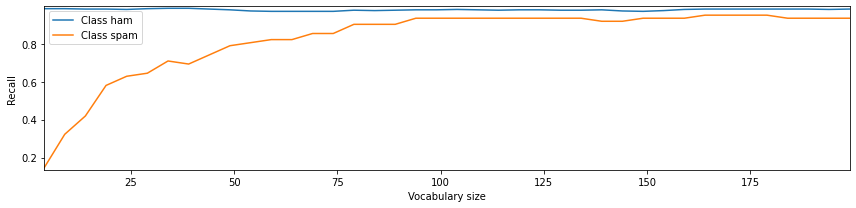

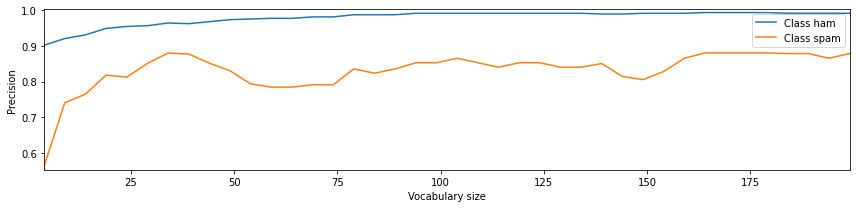

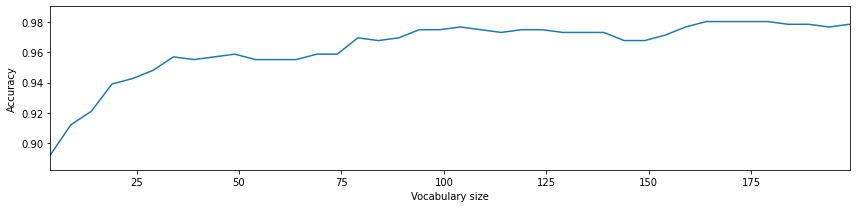

In [244]:
plot_precision_recall(X_train, y_train, X_test, y_test, BowStem)